In [1]:
# import necessary package and set up the seed so that the result can be reproducible 
from numpy.random import seed
seed(10)

from tensorflow import set_random_seed
set_random_seed(20)

# import necessary packages for loading and manipulating data
import numpy as np
import pandas as pd
import pickle

# import necessary packages for model training 
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Flatten, MaxPooling2D, Conv2D
from keras.applications.xception import Xception
from keras.models import Model
from keras.optimizers import Adam
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# import necessary packages for model evaluation
from sklearn.metrics import classification_report

# import necessary packages for visualization
import matplotlib.pyplot as plt
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay
from keras import activations 

# import other useful packages
from tqdm import tqdm 

Using TensorFlow backend.


In [2]:
#load the train, validation, and test data 
x_train = np.load('X_train.npy')
x_val = np.load('X_val.npy')
x_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_val = np.load('y_val.npy')
y_test = np.load('y_test.npy')

with open('name2idx.pickle', 'rb') as handle:
    name2idx = pickle.load(handle)

with open('idx2name.pickle', 'rb') as handle:
    idx2name = pickle.load(handle)

In [3]:
# visualize the data availability 
y_train_copy = pd.Series(y_train)
counts = y_train_copy.value_counts()
counts.rename(lambda x: idx2name[x])

Vincent van              493
Edgar Degas              394
Pablo Picasso            247
Pierre-Auguste Renoir    189
Albrecht Dürer           184
Paul Gauguin             175
Francisco Goya           163
Rembrandt                147
Alfred Sisley            145
Titian                   143
Marc Chagall             134
Rene Magritte            109
Amedeo Modigliani        109
Paul Klee                106
Henri Matisse            104
Andy Warhol              102
Mikhail Vrubel            96
Sandro Botticelli         92
Leonardo da               80
Peter Paul                79
Salvador Dali             78
Hieronymus Bosch          77
Pieter Bruegel            76
Kazimir Malevich          71
Giotto di                 67
Frida Kahlo               67
Gustav Klimt              66
Raphael                   61
Joan Miro                 58
Andrei Rublev             56
Camille Pissarro          51
Edouard Manet             51
Vasiliy Kandinskiy        50
El Greco                  49
Piet Mondrian 

Note the uneven distribution of data availability. In this notebook we are going to investigate how the utilization of transfer learning performs on the data due to this limitation and how the number of data we have for each label affects model performance. 

In [4]:
# set up necessary parameters for training 
BATCH_SIZE = 64
NUM_CLASSES = 50
INPUT_SHAPE = (331, 331, 3)

In [5]:
# set up a keras generator to scale the images for faster convergence during training and feed the model with batches
# training data 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)

In [6]:
def simple_covnet_model(num_classes, input_shape):
    '''Function to set up a simple convolutional model to be used as a baseline
    
    Arguments
    ---------
    num_classes: number of classes to classify
    input_shape: the shape of the input into the model
    
    Returns
    -------
    model: the keras model
    '''
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                    padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                    padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                    padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model 

We first fit the data with a simple convolutional network and set up a baseline score. We will improve on this score afterwards. The network has the following characteristics:
* The gradual increasing number of filters and decreasing size of the feature maps (shrunken by the max pooling layers) attempt to represent the data in a more compact manner. 
* The Dropout layers act as a regularizer so that to prevent overfitting.  

In [7]:
# print out the model summary that consists of model structure and the total number of trinable and non-trainable weights
model1 = simple_covnet_model(NUM_CLASSES, INPUT_SHAPE)
model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 331, 331, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 165, 165, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 165, 165, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 82, 82, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 82, 82, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxP

In [8]:
# compile the model 
opt = Adam(lr=1e-4)
model1.compile(
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

We then compile the model with sparse categorical crossentropy loss (it is sparse since the labels are label-encoded rather than one-hot encoded) and with Adam optimizer (for faster and stabler convergence). 

In [9]:
# set up keras callback utility 
early = EarlyStopping(monitor='val_loss', min_delta=1e-4, 
                                      patience=5, mode='auto', verbose=1,
                                      restore_best_weights=True)

We can use Keras' early stopping callback to stop the training process when the validation loss stops decreasing. Note that the patience equals to 5, which means that the callback will stop the training if the validation loss stops improving for 5 epochs. 

In [10]:
# train the model 
STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_val.shape[0] // BATCH_SIZE

history1 = model1.fit_generator(train_generator, epochs=50, steps_per_epoch=STEPS_PER_EPOCH,
                              callbacks=[early], 
                              validation_data=val_generator, verbose=1, validation_steps=VALIDATION_STEPS)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
73/73 [==============================] - ETA: 9:48 - loss: 3.9148 - acc: 0.0000e+0 - ETA: 5:00 - loss: 3.9042 - acc: 0.0234    - ETA: 3:24 - loss: 3.9045 - acc: 0.046 - ETA: 2:36 - loss: 3.8734 - acc: 0.066 - ETA: 2:06 - loss: 3.8474 - acc: 0.068 - ETA: 1:47 - loss: 3.8284 - acc: 0.075 - ETA: 1:33 - loss: 3.8108 - acc: 0.091 - ETA: 1:22 - loss: 3.8182 - acc: 0.085 - ETA: 1:14 - loss: 3.7965 - acc: 0.093 - ETA: 1:08 - loss: 3.7734 - acc: 0.098 - ETA: 1:02 - loss: 3.7859 - acc: 0.096 - ETA: 57s - loss: 3.7840 - acc: 0.097 - ETA: 53s - loss: 3.7827 - acc: 0.09 - ETA: 50s - loss: 3.7782 - acc: 0.09 - ETA: 47s - loss: 3.7728 - acc: 0.09 - ETA: 44s - loss: 3.7620 - acc: 0.09 - ETA: 42s - loss: 3.7598 - acc: 0.09 - ETA: 40s - loss: 3.7575 - acc: 0.09 - ETA: 38s - loss: 3.7548 - acc: 0.09 - ETA: 36s - loss: 3.7531 - acc: 0.08 - ETA: 34s - loss: 3.7496 - acc: 0.09 - ETA: 33s - loss: 3.7530 - acc: 0.09 - ETA: 31s - loss: 3.7555 - acc: 0.

73/73 [==============================] - ETA: 20s - loss: 2.9362 - acc: 0.29 - ETA: 20s - loss: 3.0344 - acc: 0.28 - ETA: 20s - loss: 3.1507 - acc: 0.23 - ETA: 17s - loss: 3.2224 - acc: 0.19 - ETA: 18s - loss: 3.2495 - acc: 0.19 - ETA: 18s - loss: 3.2131 - acc: 0.19 - ETA: 18s - loss: 3.1651 - acc: 0.20 - ETA: 17s - loss: 3.1334 - acc: 0.21 - ETA: 17s - loss: 3.1372 - acc: 0.21 - ETA: 17s - loss: 3.1194 - acc: 0.21 - ETA: 17s - loss: 3.1089 - acc: 0.21 - ETA: 17s - loss: 3.1004 - acc: 0.21 - ETA: 17s - loss: 3.0982 - acc: 0.21 - ETA: 16s - loss: 3.0759 - acc: 0.21 - ETA: 16s - loss: 3.0832 - acc: 0.21 - ETA: 16s - loss: 3.0664 - acc: 0.22 - ETA: 16s - loss: 3.0807 - acc: 0.21 - ETA: 15s - loss: 3.0764 - acc: 0.22 - ETA: 15s - loss: 3.0794 - acc: 0.22 - ETA: 15s - loss: 3.0810 - acc: 0.22 - ETA: 15s - loss: 3.0648 - acc: 0.22 - ETA: 14s - loss: 3.0543 - acc: 0.22 - ETA: 14s - loss: 3.0568 - acc: 0.22 - ETA: 14s - loss: 3.0682 - acc: 0.22 - ETA: 13s - loss: 3.0599 - acc: 0.22 - ETA: 13s 

73/73 [==============================] - ETA: 21s - loss: 2.6760 - acc: 0.28 - ETA: 20s - loss: 2.5574 - acc: 0.33 - ETA: 20s - loss: 2.5532 - acc: 0.31 - ETA: 20s - loss: 2.4938 - acc: 0.32 - ETA: 20s - loss: 2.4819 - acc: 0.32 - ETA: 19s - loss: 2.4928 - acc: 0.33 - ETA: 19s - loss: 2.4854 - acc: 0.32 - ETA: 18s - loss: 2.4803 - acc: 0.34 - ETA: 17s - loss: 2.4803 - acc: 0.34 - ETA: 17s - loss: 2.4742 - acc: 0.34 - ETA: 17s - loss: 2.4473 - acc: 0.34 - ETA: 17s - loss: 2.4391 - acc: 0.35 - ETA: 17s - loss: 2.4294 - acc: 0.34 - ETA: 16s - loss: 2.4650 - acc: 0.34 - ETA: 16s - loss: 2.4925 - acc: 0.33 - ETA: 16s - loss: 2.4770 - acc: 0.33 - ETA: 16s - loss: 2.4670 - acc: 0.34 - ETA: 15s - loss: 2.4551 - acc: 0.34 - ETA: 15s - loss: 2.4571 - acc: 0.34 - ETA: 15s - loss: 2.4630 - acc: 0.34 - ETA: 15s - loss: 2.4616 - acc: 0.34 - ETA: 14s - loss: 2.4743 - acc: 0.34 - ETA: 14s - loss: 2.4614 - acc: 0.34 - ETA: 14s - loss: 2.4621 - acc: 0.34 - ETA: 13s - loss: 2.4589 - acc: 0.34 - ETA: 13s 

73/73 [==============================] - ETA: 20s - loss: 1.9229 - acc: 0.46 - ETA: 20s - loss: 1.8688 - acc: 0.48 - ETA: 20s - loss: 1.9616 - acc: 0.45 - ETA: 20s - loss: 1.9776 - acc: 0.45 - ETA: 19s - loss: 1.9973 - acc: 0.45 - ETA: 19s - loss: 1.9448 - acc: 0.47 - ETA: 19s - loss: 1.9963 - acc: 0.45 - ETA: 19s - loss: 1.9824 - acc: 0.46 - ETA: 18s - loss: 1.9943 - acc: 0.46 - ETA: 18s - loss: 1.9688 - acc: 0.47 - ETA: 18s - loss: 1.9655 - acc: 0.47 - ETA: 17s - loss: 1.9656 - acc: 0.46 - ETA: 16s - loss: 1.9520 - acc: 0.47 - ETA: 16s - loss: 1.9248 - acc: 0.48 - ETA: 16s - loss: 1.9105 - acc: 0.48 - ETA: 16s - loss: 1.9107 - acc: 0.48 - ETA: 15s - loss: 1.9159 - acc: 0.48 - ETA: 15s - loss: 1.9132 - acc: 0.48 - ETA: 15s - loss: 1.8971 - acc: 0.49 - ETA: 15s - loss: 1.8833 - acc: 0.49 - ETA: 14s - loss: 1.8641 - acc: 0.49 - ETA: 14s - loss: 1.8531 - acc: 0.49 - ETA: 14s - loss: 1.8668 - acc: 0.49 - ETA: 14s - loss: 1.8625 - acc: 0.49 - ETA: 13s - loss: 1.8554 - acc: 0.49 - ETA: 13s 

73/73 [==============================] - ETA: 21s - loss: 1.1753 - acc: 0.71 - ETA: 20s - loss: 1.2540 - acc: 0.67 - ETA: 20s - loss: 1.2270 - acc: 0.68 - ETA: 20s - loss: 1.2464 - acc: 0.66 - ETA: 20s - loss: 1.2765 - acc: 0.64 - ETA: 19s - loss: 1.2652 - acc: 0.64 - ETA: 19s - loss: 1.2999 - acc: 0.63 - ETA: 19s - loss: 1.2902 - acc: 0.64 - ETA: 19s - loss: 1.2799 - acc: 0.64 - ETA: 18s - loss: 1.2890 - acc: 0.64 - ETA: 18s - loss: 1.2899 - acc: 0.63 - ETA: 18s - loss: 1.3117 - acc: 0.63 - ETA: 17s - loss: 1.3054 - acc: 0.62 - ETA: 17s - loss: 1.3014 - acc: 0.63 - ETA: 17s - loss: 1.3070 - acc: 0.62 - ETA: 16s - loss: 1.2991 - acc: 0.62 - ETA: 16s - loss: 1.2793 - acc: 0.63 - ETA: 15s - loss: 1.2750 - acc: 0.64 - ETA: 15s - loss: 1.2641 - acc: 0.64 - ETA: 15s - loss: 1.2635 - acc: 0.64 - ETA: 15s - loss: 1.2566 - acc: 0.65 - ETA: 14s - loss: 1.2504 - acc: 0.65 - ETA: 14s - loss: 1.2458 - acc: 0.65 - ETA: 14s - loss: 1.2357 - acc: 0.66 - ETA: 14s - loss: 1.2310 - acc: 0.66 - ETA: 13s 

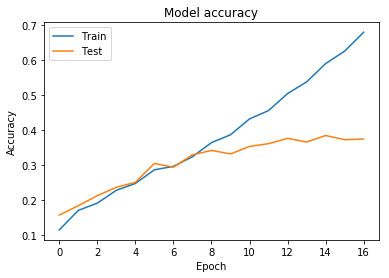

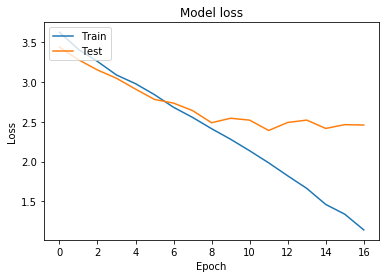

In [11]:
def result_plot(history):
    '''Function to visualize loss and accuracy curve
    
    Arguments
    ---------
    history: variable that stores the model training results
    '''
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
result_plot(history=history1)

Note that the training and testing curve start diverging at epoch 8 for both accuracy and loss. This shows that the model overfits even though regularization measures are applied. 

In [12]:
# set up new set of keras generators for data augumentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)

We can then try data augmentation (perform random transformations of our images) on the training data to reduce the problem of overfitting. 

In [13]:
# reinitialize and recompile our new model 
model1 = simple_covnet_model(NUM_CLASSES, INPUT_SHAPE)

opt = Adam(lr=1e-4)
model1.compile(
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

history2 = model1.fit_generator(train_generator, epochs=50, steps_per_epoch=STEPS_PER_EPOCH,
                              callbacks=[early], 
                              validation_data=val_generator, verbose=1, validation_steps=VALIDATION_STEPS)

Epoch 1/50
73/73 [==============================] - ETA: 6:10 - loss: 3.9094 - acc: 0.0000e+0 - ETA: 3:13 - loss: 3.8918 - acc: 0.0234    - ETA: 2:45 - loss: 3.8531 - acc: 0.041 - ETA: 2:37 - loss: 3.8142 - acc: 0.054 - ETA: 2:30 - loss: 3.8278 - acc: 0.053 - ETA: 2:25 - loss: 3.8465 - acc: 0.052 - ETA: 2:21 - loss: 3.8494 - acc: 0.051 - ETA: 2:17 - loss: 3.8193 - acc: 0.056 - ETA: 2:14 - loss: 3.7838 - acc: 0.062 - ETA: 2:11 - loss: 3.7747 - acc: 0.060 - ETA: 2:08 - loss: 3.7582 - acc: 0.066 - ETA: 2:06 - loss: 3.7688 - acc: 0.069 - ETA: 2:04 - loss: 3.7634 - acc: 0.074 - ETA: 2:02 - loss: 3.7621 - acc: 0.079 - ETA: 2:00 - loss: 3.7551 - acc: 0.080 - ETA: 1:57 - loss: 3.7391 - acc: 0.083 - ETA: 1:54 - loss: 3.7358 - acc: 0.085 - ETA: 1:51 - loss: 3.7381 - acc: 0.083 - ETA: 1:49 - loss: 3.7414 - acc: 0.084 - ETA: 1:47 - loss: 3.7318 - acc: 0.086 - ETA: 1:45 - loss: 3.7355 - acc: 0.085 - ETA: 1:43 - loss: 3.7396 - acc: 0.085 - ETA: 1:41 - loss: 3.7350 - acc: 0.084 - ETA: 1:38 - loss: 3.

73/73 [==============================] - ETA: 24s - loss: 2.9647 - acc: 0.28 - ETA: 1:41 - loss: 2.9946 - acc: 0.234 - ETA: 1:58 - loss: 3.0843 - acc: 0.208 - ETA: 1:41 - loss: 3.0711 - acc: 0.221 - ETA: 1:51 - loss: 3.0927 - acc: 0.220 - ETA: 1:55 - loss: 3.1136 - acc: 0.209 - ETA: 1:59 - loss: 3.1303 - acc: 0.202 - ETA: 2:01 - loss: 3.1290 - acc: 0.206 - ETA: 2:01 - loss: 3.1333 - acc: 0.207 - ETA: 2:02 - loss: 3.1022 - acc: 0.213 - ETA: 2:02 - loss: 3.1093 - acc: 0.211 - ETA: 2:02 - loss: 3.0969 - acc: 0.214 - ETA: 2:01 - loss: 3.1107 - acc: 0.212 - ETA: 2:00 - loss: 3.1048 - acc: 0.216 - ETA: 1:58 - loss: 3.0992 - acc: 0.218 - ETA: 1:57 - loss: 3.0954 - acc: 0.218 - ETA: 1:56 - loss: 3.1081 - acc: 0.212 - ETA: 1:54 - loss: 3.1208 - acc: 0.209 - ETA: 1:52 - loss: 3.1214 - acc: 0.207 - ETA: 1:50 - loss: 3.1174 - acc: 0.209 - ETA: 1:48 - loss: 3.1046 - acc: 0.214 - ETA: 1:46 - loss: 3.1206 - acc: 0.213 - ETA: 1:43 - loss: 3.1278 - acc: 0.213 - ETA: 1:41 - loss: 3.1229 - acc: 0.213 - E

73/73 [==============================] - ETA: 31s - loss: 2.8628 - acc: 0.26 - ETA: 1:42 - loss: 2.8074 - acc: 0.273 - ETA: 1:53 - loss: 2.8361 - acc: 0.260 - ETA: 1:56 - loss: 2.7730 - acc: 0.285 - ETA: 1:58 - loss: 2.8085 - acc: 0.278 - ETA: 1:59 - loss: 2.7642 - acc: 0.278 - ETA: 2:00 - loss: 2.7830 - acc: 0.272 - ETA: 1:49 - loss: 2.7987 - acc: 0.266 - ETA: 1:50 - loss: 2.8043 - acc: 0.267 - ETA: 1:50 - loss: 2.8041 - acc: 0.272 - ETA: 1:49 - loss: 2.7867 - acc: 0.281 - ETA: 1:49 - loss: 2.7901 - acc: 0.285 - ETA: 1:48 - loss: 2.7804 - acc: 0.288 - ETA: 1:47 - loss: 2.7857 - acc: 0.284 - ETA: 1:45 - loss: 2.7760 - acc: 0.284 - ETA: 1:44 - loss: 2.7835 - acc: 0.285 - ETA: 1:43 - loss: 2.8077 - acc: 0.280 - ETA: 1:41 - loss: 2.8078 - acc: 0.282 - ETA: 1:40 - loss: 2.8015 - acc: 0.284 - ETA: 1:38 - loss: 2.8113 - acc: 0.282 - ETA: 1:37 - loss: 2.8223 - acc: 0.278 - ETA: 1:35 - loss: 2.8177 - acc: 0.278 - ETA: 1:33 - loss: 2.8323 - acc: 0.276 - ETA: 1:32 - loss: 2.8326 - acc: 0.276 - E

73/73 [==============================] - ETA: 29s - loss: 2.3671 - acc: 0.39 - ETA: 1:42 - loss: 2.5442 - acc: 0.351 - ETA: 1:51 - loss: 2.5463 - acc: 0.333 - ETA: 1:55 - loss: 2.6728 - acc: 0.300 - ETA: 1:55 - loss: 2.6714 - acc: 0.284 - ETA: 1:55 - loss: 2.6696 - acc: 0.289 - ETA: 1:54 - loss: 2.7156 - acc: 0.281 - ETA: 1:54 - loss: 2.7214 - acc: 0.287 - ETA: 1:52 - loss: 2.7374 - acc: 0.281 - ETA: 1:52 - loss: 2.7054 - acc: 0.293 - ETA: 1:51 - loss: 2.6901 - acc: 0.296 - ETA: 1:43 - loss: 2.6694 - acc: 0.303 - ETA: 1:43 - loss: 2.6443 - acc: 0.304 - ETA: 1:42 - loss: 2.6393 - acc: 0.307 - ETA: 1:40 - loss: 2.6540 - acc: 0.304 - ETA: 1:39 - loss: 2.6490 - acc: 0.299 - ETA: 1:38 - loss: 2.6419 - acc: 0.296 - ETA: 1:36 - loss: 2.6468 - acc: 0.297 - ETA: 1:35 - loss: 2.6510 - acc: 0.294 - ETA: 1:34 - loss: 2.6473 - acc: 0.293 - ETA: 1:32 - loss: 2.6522 - acc: 0.294 - ETA: 1:31 - loss: 2.6585 - acc: 0.290 - ETA: 1:29 - loss: 2.6513 - acc: 0.292 - ETA: 1:28 - loss: 2.6420 - acc: 0.292 - E

73/73 [==============================] - ETA: 32s - loss: 2.6489 - acc: 0.34 - ETA: 1:41 - loss: 2.4126 - acc: 0.343 - ETA: 1:52 - loss: 2.5089 - acc: 0.333 - ETA: 1:57 - loss: 2.4689 - acc: 0.351 - ETA: 2:02 - loss: 2.4532 - acc: 0.365 - ETA: 2:02 - loss: 2.4867 - acc: 0.343 - ETA: 2:03 - loss: 2.5048 - acc: 0.343 - ETA: 2:01 - loss: 2.5269 - acc: 0.337 - ETA: 2:00 - loss: 2.5211 - acc: 0.336 - ETA: 1:59 - loss: 2.5223 - acc: 0.328 - ETA: 1:57 - loss: 2.5391 - acc: 0.319 - ETA: 1:55 - loss: 2.5171 - acc: 0.326 - ETA: 1:53 - loss: 2.5168 - acc: 0.323 - ETA: 1:52 - loss: 2.5155 - acc: 0.323 - ETA: 1:50 - loss: 2.5231 - acc: 0.319 - ETA: 1:44 - loss: 2.5319 - acc: 0.325 - ETA: 1:42 - loss: 2.5219 - acc: 0.330 - ETA: 1:41 - loss: 2.5164 - acc: 0.330 - ETA: 1:39 - loss: 2.5214 - acc: 0.327 - ETA: 1:37 - loss: 2.5232 - acc: 0.324 - ETA: 1:35 - loss: 2.5383 - acc: 0.321 - ETA: 1:34 - loss: 2.5391 - acc: 0.323 - ETA: 1:32 - loss: 2.5371 - acc: 0.324 - ETA: 1:31 - loss: 2.5387 - acc: 0.326 - E

73/73 [==============================] - ETA: 25s - loss: 2.4028 - acc: 0.42 - ETA: 1:39 - loss: 2.3703 - acc: 0.390 - ETA: 1:48 - loss: 2.3738 - acc: 0.364 - ETA: 1:53 - loss: 2.3915 - acc: 0.359 - ETA: 1:53 - loss: 2.3898 - acc: 0.356 - ETA: 1:53 - loss: 2.4086 - acc: 0.335 - ETA: 1:52 - loss: 2.4223 - acc: 0.332 - ETA: 1:52 - loss: 2.4119 - acc: 0.339 - ETA: 1:51 - loss: 2.4170 - acc: 0.340 - ETA: 1:50 - loss: 2.4607 - acc: 0.328 - ETA: 1:49 - loss: 2.4591 - acc: 0.329 - ETA: 1:48 - loss: 2.4635 - acc: 0.326 - ETA: 1:47 - loss: 2.4740 - acc: 0.325 - ETA: 1:46 - loss: 2.4475 - acc: 0.334 - ETA: 1:44 - loss: 2.4435 - acc: 0.332 - ETA: 1:43 - loss: 2.4551 - acc: 0.332 - ETA: 1:41 - loss: 2.4539 - acc: 0.330 - ETA: 1:39 - loss: 2.4684 - acc: 0.325 - ETA: 1:38 - loss: 2.4685 - acc: 0.324 - ETA: 1:33 - loss: 2.4586 - acc: 0.329 - ETA: 1:32 - loss: 2.4653 - acc: 0.331 - ETA: 1:30 - loss: 2.4680 - acc: 0.327 - ETA: 1:29 - loss: 2.4618 - acc: 0.326 - ETA: 1:28 - loss: 2.4439 - acc: 0.331 - E

73/73 [==============================] - ETA: 27s - loss: 2.0352 - acc: 0.39 - ETA: 1:40 - loss: 2.1756 - acc: 0.367 - ETA: 1:51 - loss: 2.2301 - acc: 0.354 - ETA: 1:57 - loss: 2.1700 - acc: 0.375 - ETA: 1:59 - loss: 2.2433 - acc: 0.359 - ETA: 2:00 - loss: 2.2740 - acc: 0.351 - ETA: 1:59 - loss: 2.3008 - acc: 0.348 - ETA: 1:58 - loss: 2.3158 - acc: 0.337 - ETA: 1:58 - loss: 2.3085 - acc: 0.345 - ETA: 1:59 - loss: 2.2945 - acc: 0.343 - ETA: 1:56 - loss: 2.2690 - acc: 0.356 - ETA: 1:55 - loss: 2.2742 - acc: 0.360 - ETA: 1:55 - loss: 2.2831 - acc: 0.363 - ETA: 1:53 - loss: 2.3014 - acc: 0.360 - ETA: 1:53 - loss: 2.3026 - acc: 0.363 - ETA: 1:51 - loss: 2.3075 - acc: 0.359 - ETA: 1:49 - loss: 2.3114 - acc: 0.361 - ETA: 1:47 - loss: 2.3172 - acc: 0.362 - ETA: 1:45 - loss: 2.3179 - acc: 0.359 - ETA: 1:43 - loss: 2.3103 - acc: 0.364 - ETA: 1:41 - loss: 2.3134 - acc: 0.362 - ETA: 1:39 - loss: 2.3077 - acc: 0.362 - ETA: 1:37 - loss: 2.3085 - acc: 0.362 - ETA: 1:32 - loss: 2.3350 - acc: 0.356 - E

73/73 [==============================] - ETA: 20s - loss: 2.2213 - acc: 0.34 - ETA: 1:36 - loss: 2.3855 - acc: 0.328 - ETA: 1:47 - loss: 2.3664 - acc: 0.328 - ETA: 1:52 - loss: 2.2604 - acc: 0.351 - ETA: 1:55 - loss: 2.2676 - acc: 0.365 - ETA: 1:57 - loss: 2.2947 - acc: 0.359 - ETA: 1:57 - loss: 2.2439 - acc: 0.375 - ETA: 1:57 - loss: 2.2395 - acc: 0.384 - ETA: 1:55 - loss: 2.2324 - acc: 0.388 - ETA: 1:54 - loss: 2.2340 - acc: 0.392 - ETA: 1:53 - loss: 2.1994 - acc: 0.403 - ETA: 1:52 - loss: 2.2012 - acc: 0.398 - ETA: 1:51 - loss: 2.2095 - acc: 0.401 - ETA: 1:49 - loss: 2.2097 - acc: 0.407 - ETA: 1:48 - loss: 2.1998 - acc: 0.407 - ETA: 1:45 - loss: 2.2025 - acc: 0.407 - ETA: 1:44 - loss: 2.2218 - acc: 0.401 - ETA: 1:42 - loss: 2.2284 - acc: 0.402 - ETA: 1:41 - loss: 2.2455 - acc: 0.400 - ETA: 1:39 - loss: 2.2421 - acc: 0.400 - ETA: 1:38 - loss: 2.2306 - acc: 0.401 - ETA: 1:36 - loss: 2.2309 - acc: 0.402 - ETA: 1:34 - loss: 2.2352 - acc: 0.397 - ETA: 1:32 - loss: 2.2327 - acc: 0.394 - E

We then set up a new model to train it on generated augumented data. Notice how the training has slowed due to the extra step of data augmentation. 

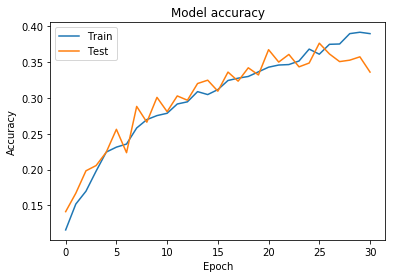

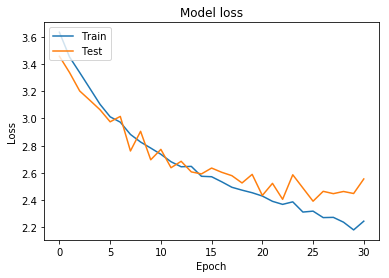

In [14]:
result_plot(history=history2)

Note the testing curve follows closely with the training curve for both accuracy and loss. This shows that data augmentation indeed helps to mitigate the problem of overfitting. However, the final result shows no significant improvement over the previous model. 

Therefore, we can consider using pretrained model with smarter model architecture and pretrained weights to improve our model performance. 

In [6]:
# function to train a transfer learning model using Xception network as our base model 
def transfer_learning_model(num_classes, input_shape):
    '''Function to train a transfer learning model using Xception network as our base model
    
    Arguments
    ---------
    num_classes: number of classes to classify
    input_shape: shape of the input into the model
    
    Returns
    -------
    model: the keras model 
    '''
    # set up the Xception base model and exclude the top layers of the original network
    base_model = Xception(weights='imagenet', include_top=False,
                   input_shape=INPUT_SHAPE)
    # freeze all the layers of the original network 
    for layer in base_model.layers:
        layer.trainable = False
    # put our dense layers on top of the original network
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    # increase dropout rate to prevent overfitting
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model 

model2 = transfer_learning_model(NUM_CLASSES, INPUT_SHAPE)
model2.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 165, 165, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 165, 165, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Act

block8_sepconv3_bn (BatchNormal (None, 21, 21, 728)  2912        block8_sepconv3[0][0]            
__________________________________________________________________________________________________
add_7 (Add)                     (None, 21, 21, 728)  0           block8_sepconv3_bn[0][0]         
                                                                 add_6[0][0]                      
__________________________________________________________________________________________________
block9_sepconv1_act (Activation (None, 21, 21, 728)  0           add_7[0][0]                      
__________________________________________________________________________________________________
block9_sepconv1 (SeparableConv2 (None, 21, 21, 728)  536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 21, 21, 728)  2912        block9_sepconv1[0][0]            
__________

The main reason why our networks so far give such poor result is our lack of data. Therefore we can use pretrained model with pretrained weights to compensate for this deficiency. For this notebook we are going to make sure of the Xception model initialized with weights trained on the Imagenet dataset. We are going to exclude the top layers of the original network and train our dense layers on top of the frozen layers of the original network. In other words, the original network is used as a feature extractor for our dense layers network. 

In [20]:
import keras
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='models_saved/weights-improvement-{epoch:02d}-{val_loss:.4f}-bigger.hdf5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss')

In [21]:
# retrain our data using the transfer model and the same configuration as before
opt = Adam(lr=1e-4)
model2.compile(
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

STEPS_PER_EPOCH = x_train.shape[0] // BATCH_SIZE
VALIDATION_STEPS = x_val.shape[0] // BATCH_SIZE

history3 = model2.fit_generator(train_generator, epochs=50, steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=[checkpoint_callback, early], 
                                validation_data=val_generator, verbose=1, validation_steps=VALIDATION_STEPS)

Epoch 1/50
73/73 [==============================] - 158s 2s/step - loss: 3.6951 - acc: 0.0963 - val_loss: 3.5166 - val_acc: 0.1544
Epoch 2/50
73/73 [==============================] - 131s 2s/step - loss: 3.4504 - acc: 0.1528 - val_loss: 3.3173 - val_acc: 0.1863
Epoch 3/50
73/73 [==============================] - 141s 2s/step - loss: 3.2416 - acc: 0.2104 - val_loss: 3.0853 - val_acc: 0.2415
Epoch 4/50
73/73 [==============================] - 140s 2s/step - loss: 3.0128 - acc: 0.2563 - val_loss: 2.9047 - val_acc: 0.2695
Epoch 5/50
73/73 [==============================] - 139s 2s/step - loss: 2.8109 - acc: 0.3000 - val_loss: 2.7636 - val_acc: 0.3014
Epoch 6/50
73/73 [==============================] - 140s 2s/step - loss: 2.6598 - acc: 0.3298 - val_loss: 2.6221 - val_acc: 0.3327
Epoch 7/50
73/73 [==============================] - 139s 2s/step - loss: 2.5300 - acc: 0.3543 - val_loss: 2.4953 - val_acc: 0.3613
Epoch 8/50
73/73 [==============================] - 141s 2s/step - loss: 2.3800 - a

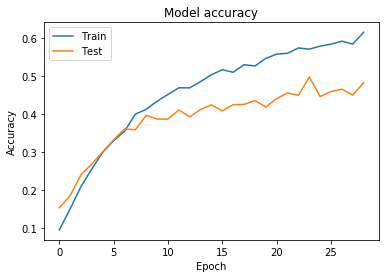

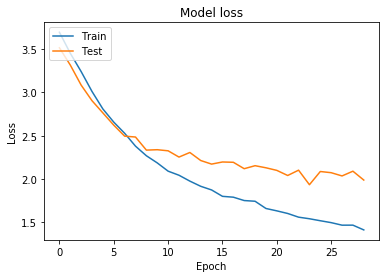

In [24]:
result_plot(history=history3)

The resulting graph shows two following characteristics: 
* Notice how the final validation loss has improved (it is reduced to around 2) compared to our previous results.  
* Notice also how the problem of overfitting has worsened compared to the previous model even though the dropout rate has increased.  

In [25]:
# unfrozen the upper layers of the original network for fine tuning 
for layer in model2.layers[96:]:
    layer.trainable = True

opt = Adam(lr=1e-4)
model2.compile(
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

model2.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 331, 331, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 165, 165, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 165, 165, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 165, 165, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

We can further improve the model by unfreezing few of the top layers of the original network and fine tune these weights to fit our data. We did not do this at the beginning of our training because at the beginning, the weights update for our dense layers on the top would be huge and so will be the weights update for the original network. We, however, only want to fine tune the original network weights rather than significantly changing them. 

In [26]:
# fine tune the model
history4 = model2.fit_generator(train_generator, epochs=50, steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=[checkpoint_callback, early], 
                                validation_data=val_generator, verbose=1, validation_steps=VALIDATION_STEPS)

Epoch 1/50
73/73 [==============================] - 171s 2s/step - loss: 1.3804 - acc: 0.6099 - val_loss: 1.6343 - val_acc: 0.5602
Epoch 2/50
73/73 [==============================] - 163s 2s/step - loss: 1.0947 - acc: 0.6875 - val_loss: 1.5315 - val_acc: 0.5902
Epoch 3/50
73/73 [==============================] - 161s 2s/step - loss: 0.9070 - acc: 0.7417 - val_loss: 1.4659 - val_acc: 0.6028
Epoch 4/50
73/73 [==============================] - 154s 2s/step - loss: 0.7605 - acc: 0.7786 - val_loss: 1.5000 - val_acc: 0.5895
Epoch 5/50
73/73 [==============================] - 151s 2s/step - loss: 0.6371 - acc: 0.8175 - val_loss: 1.2956 - val_acc: 0.6567
Epoch 6/50
73/73 [==============================] - 152s 2s/step - loss: 0.5290 - acc: 0.8495 - val_loss: 1.3892 - val_acc: 0.6314
Epoch 7/50
73/73 [==============================] - 151s 2s/step - loss: 0.4397 - acc: 0.8718 - val_loss: 1.3245 - val_acc: 0.6733
Epoch 8/50
73/73 [==============================] - 151s 2s/step - loss: 0.3695 - a

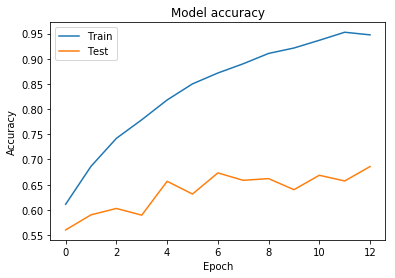

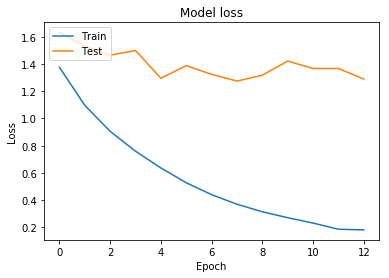

In [27]:
result_plot(history=history4)

The results show that although overfitting problem is serious, the model offers significant improvement over our previous models (loss is reduced to 1.3 and accuracy is increased to an acceptable 67 percent)

In [7]:
model2.load_weights('models_saved/weights-improvement-08-1.2750-bigger.hdf5')

opt = Adam(lr=1e-4)
model2.compile(
    optimizer = opt,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

# scale the test data for prediction
x_test_scaled = x_test / 255.

# compute the logit values and the final predictions for the test data
y_test_logit = model2.predict(x_test_scaled)
y_test_pred = np.argmax(y_test_logit, axis=1)

# compute the evaluation metrics such as precision and recall for each unique test labels
report = classification_report(y_test, y_test_pred, target_names=list(idx2name), output_dict=True)

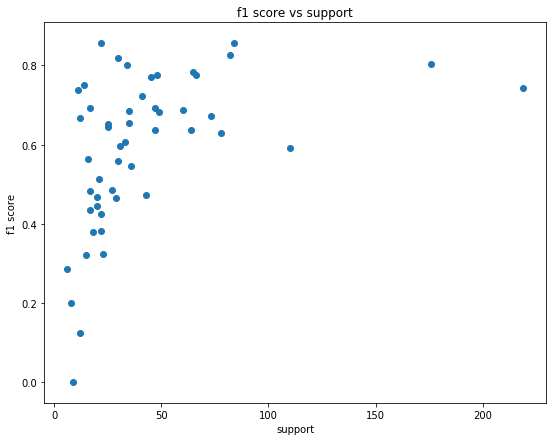

In [40]:
# plot f1 score vs support
f1_score = [artist['f1-score'] for artist in report.values()][:-3]
support = [artist['support'] for artist in report.values()][:-3]

plt.figure(figsize=(9,7))
plt.scatter(support, f1_score)
plt.title('f1 score vs support')
plt.xlabel('support')
plt.ylabel('f1 score')
plt.show()


By plotting the f1 scores (measure of good balance between precision and recall score) for different classes and their support (the number of data points of these classes we have available), we can see how availability of data affects model performance. Unsurprisingly, the plot shows how performance increases rapidly with increasing data availability and with decreasing rate until  it reaches a threshold. 

In [8]:
# we can use keras_vis package to change the softmax activation function in the last layer for a linear activation function
# this is done because the gradient of an output category through the softmax function with respective to the pixels 
# depends on other output categories. Therefore switching the activation function to linear eliminates the impact of these 
# output categories to the gradient computation. 
model_vis = model2
model_vis.layers[-1].activation = activations.linear
model_vis = utils.apply_modifications(model_vis)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:08<00:00, 74.30s/it]


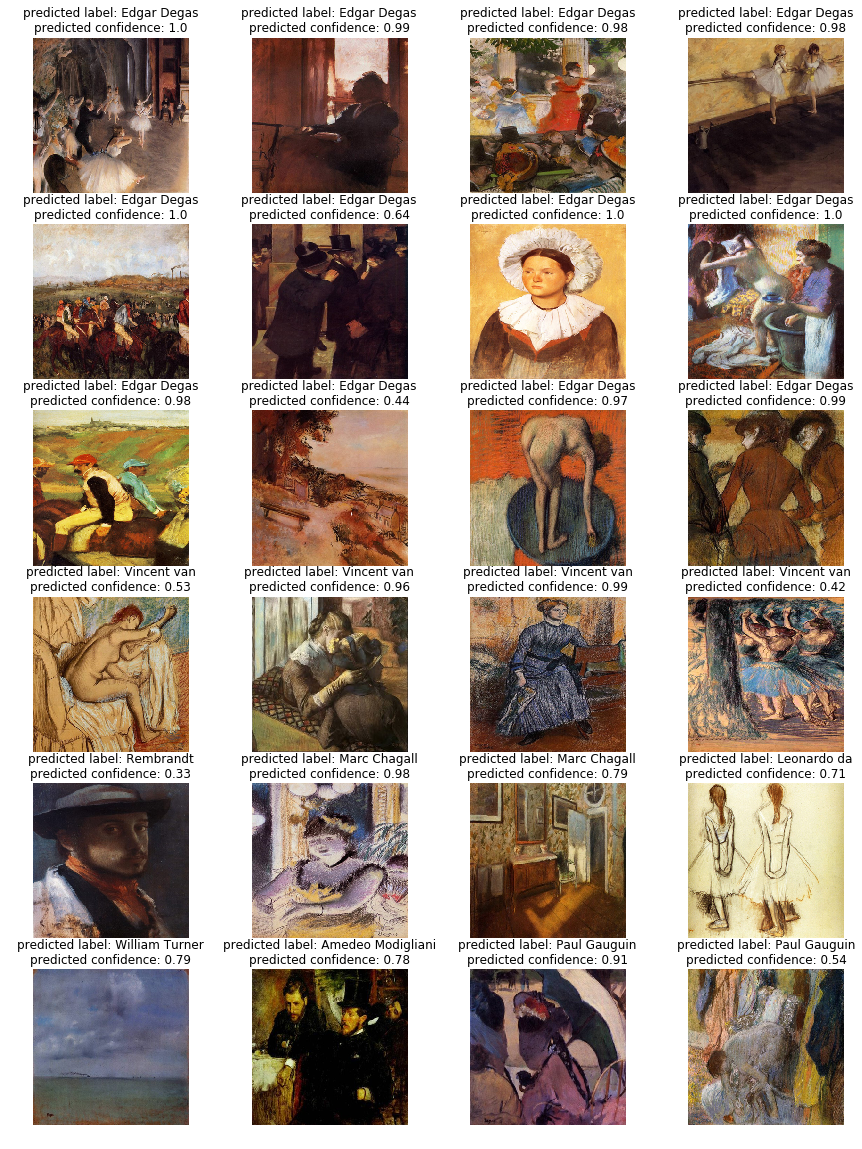

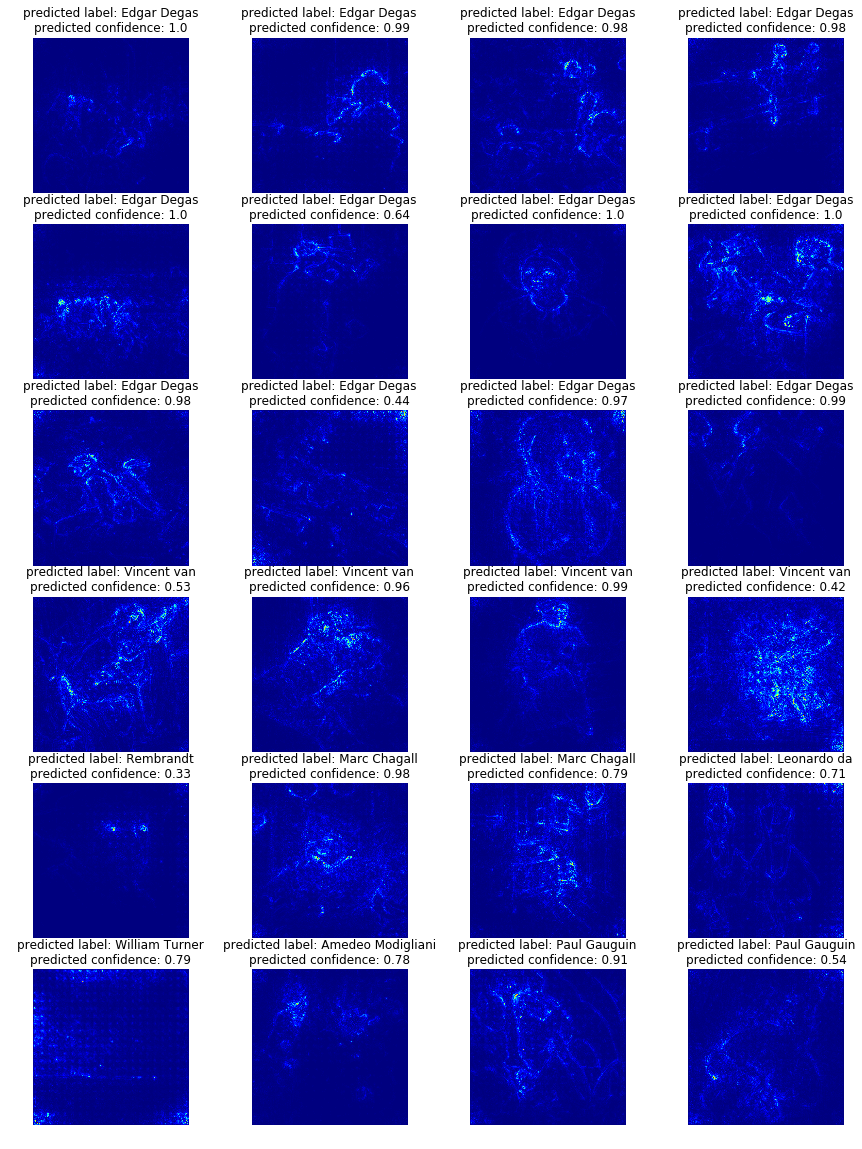

In [10]:
def painting_classification_result_plot(img_class, imgs_per_class=12, width=4, height=6, is_saliency=False):
    '''Function to plot relevant results for analysis
    
    Arguments
    ---------
    img_class: pick an image class to do analysis on
    imgs_per_class: the number of images that are correctly classified as img_class and the number of images that are incorrectly classified as other classes
    width: the number of images per row
    height: the number of images per column
    is_saliency: whether to plot saliency maps of these images
    '''
    # set up the size of the whole figure
    f, ax = plt.subplots(height, width)
    f.set_size_inches(15, 20)

    # get the predicted labels, true labels, test data, and test labels for analysis
    predicted_labels = y_test_pred[y_test == img_class]
    true_labels = y_test[y_test == img_class]
    x_test_scaled_sampled = x_test_scaled[y_test == img_class]
    y_test_logit_sampled = y_test_logit[y_test == img_class]

    # index for correctly and incorrectly classified images 
    fail_idx = np.where(predicted_labels != true_labels)[0][:imgs_per_class]
    good_idx = np.where(predicted_labels == true_labels)[0][:imgs_per_class]

    # double loop to plot a grid of images or their corresponding saliency maps 
    img_idx = 0
    for i in tqdm(range(height)):
        for j in range(width):
            # get information on correctly classified images 
            if img_idx < imgs_per_class:
                predicted_label = predicted_labels[good_idx[img_idx]] # get the predicted labels
                predicted_conf = round(np.amax(y_test_logit_sampled[good_idx[img_idx],:]), 2) # get the corresponding logit value
                img = x_test_scaled_sampled[good_idx[img_idx]] # get the raw image
                grads = visualize_saliency(model2, -1, filter_indices=predicted_label,
                                           seed_input=img, backprop_modifier='guided') # compute the gradient for saliency map
            # get information on incorrectly classified images 
            else:
                predicted_label = predicted_labels[fail_idx[img_idx-imgs_per_class]]
                predicted_conf = round(np.amax(y_test_logit_sampled[fail_idx[img_idx-imgs_per_class],:]), 2)
                img = x_test_scaled_sampled[fail_idx[img_idx-imgs_per_class]]
                grads = visualize_saliency(model2, -1, filter_indices=predicted_label,
                                           seed_input=img, backprop_modifier='guided')
            
            # set the title that shows the predicted label and confidence of the model decisions and plot raw images or their corresponding saliency maps
            ax[i][j].axis('off')
            ax[i][j].set_title('predicted label: ' + str(idx2name[predicted_label]) + '\npredicted confidence: ' + str(predicted_conf))
            if is_saliency:
                ax[i][j].imshow(grads, cmap='jet')
            else:
                ax[i][j].imshow(img)
            img_idx += 1

# plot the raw images followed by their corresponding saliency maps 
painting_classification_result_plot(img_class=10, is_saliency=False)
painting_classification_result_plot(img_class=10, is_saliency=True)

Let's pick one artist to do some more analysis on the model results (in this case, the French artist Edgar Degas).

The above plotted the following:
* The first set of paintings contain the correctly (true positives) and incorrectly (false negatives) paintings by Edgar Degas
* The second set of paintings use the same paintings from the first set but this time are shown in terms of saliency maps (the more high-lighted the points are, the larger the gradient of the ouput category with respect to pixels in question. Therefore, the high-lighted points show those pixels that contribute most to model decisions).
* For each set of paintings, the first three rows show the correctly classified ones and the rest incorrectly classified ones.
* The title of each painting specifies the predicted label and the confidence (the largest logit value) with which the painting is classified. 

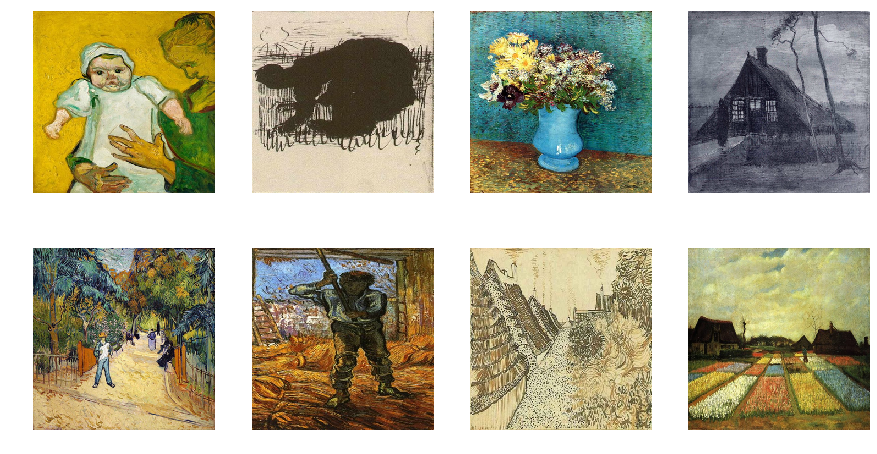

In [15]:
def plot_most_similar_artist(img_class, width=4, height=2):
    '''Function to plot images of certain artist
    
    Arguments
    ---------
    img_class: image class
    width: the number of images per row
    height: the number of images per column 
    '''
    f, ax = plt.subplots(height, width)
    f.set_size_inches(15, 8)

    predicted_labels = y_test_pred[y_test == img_class]
    true_labels = y_test[y_test == img_class]
    x_test_scaled_sampled = x_test_scaled[y_test == img_class]
    good_idx = np.where(predicted_labels == true_labels)[0][:width*height]

    img_idx = 0
    for i in range(height):
        for j in range(width):
            img = x_test_scaled_sampled[good_idx[img_idx]]
            ax[i][j].axis('off')
            ax[i][j].imshow(img)
            img_idx += 1

# plot few paintings by Van Gogh
plot_most_similar_artist(48)

We first focus our attention on the original paintings. We can make the following observations:
* Note, for example, that the first four misclassified paintings are all classified as by Dutch artist Vincent van Gogh (some of them with very high confidence). We can investigate this further by looking at a few of van Gogh's works, which are plotted above.
* we can see some stylish similarity between van Gogh's works with the misclassified paintings. 

Then we can look deeper into model decisions by focusing our attention on saliency maps: 
* For both correctly and incorrectly classified paintings, the most important part of the portrait paintings that contribute to the model's decision is the head/heads of the person/persons involved. 
* Unsuprisingly, for both correctly and incorrectly classified paintings, those paintings that are classified with high confidence seem to have saliency points concentrated in specific parts of the paintings while those with low confidence seem to have saliency points spread rather uniformly throughout the paintings. This is similar to how we as humans classify paintings. When we can identify a painting with high confidence, we can often explain ourselves by pointing out the specific part of the painting that catches our attention, something that we are unable to do when we only have a vague idea who actually painted the painting. 

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [14:20<00:00, 147.70s/it]


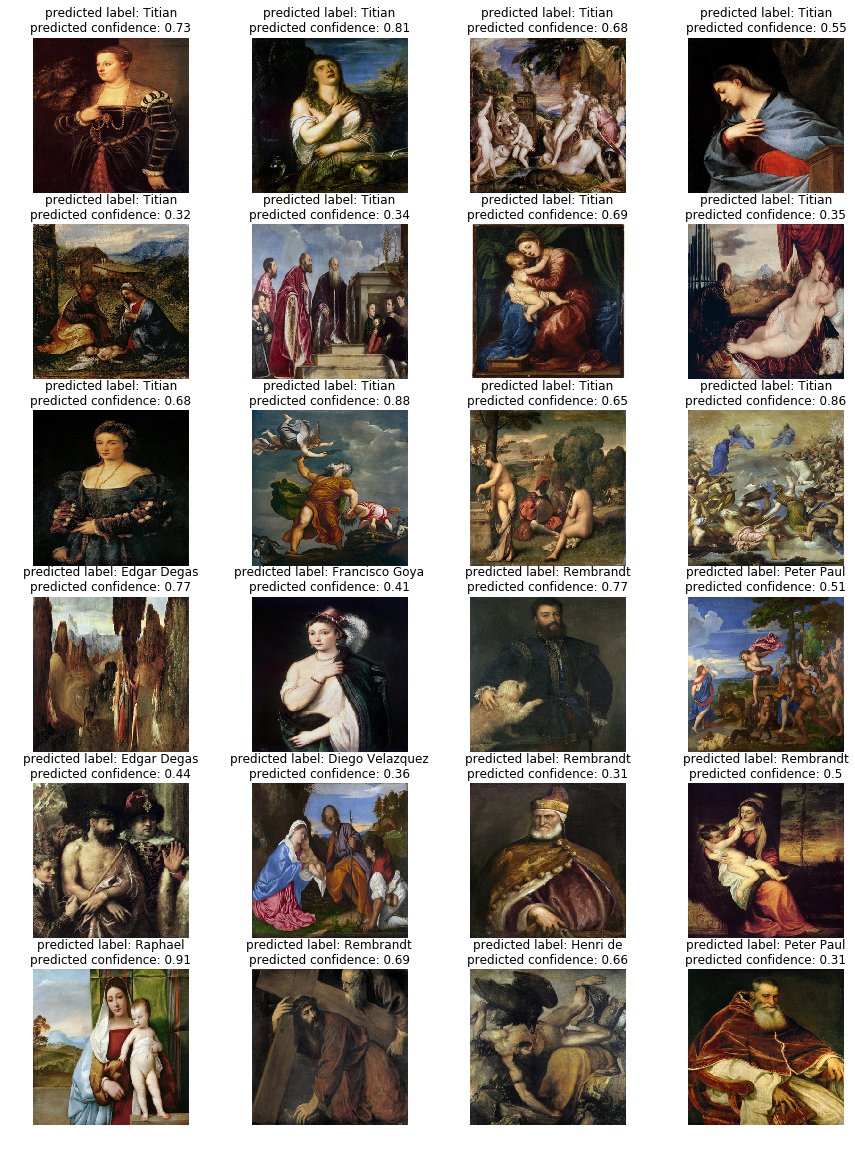

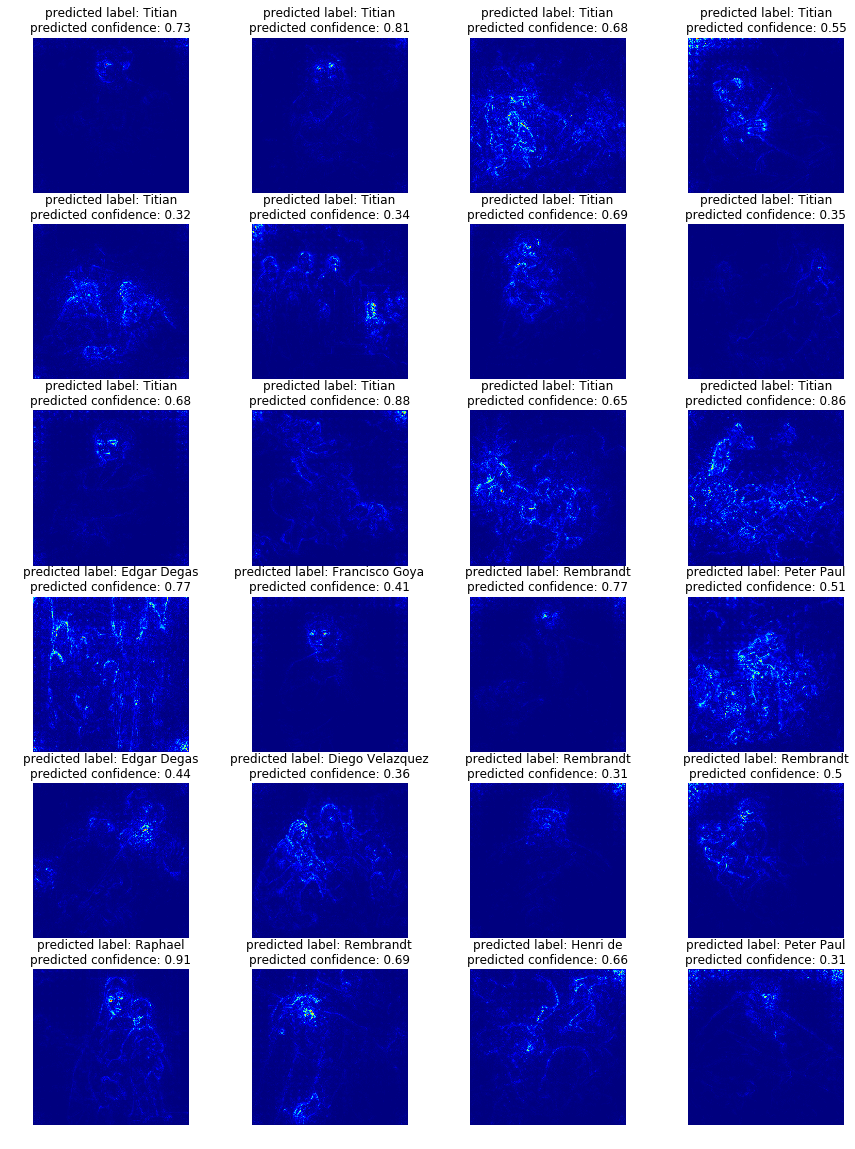

In [11]:
painting_classification_result_plot(img_class=46, is_saliency=False)
painting_classification_result_plot(img_class=46, is_saliency=True)

Next we look at another set of paintings by Titian, an Italian artist from the Renaissance period. This is to see how model decisions vary with artists from different periods. 

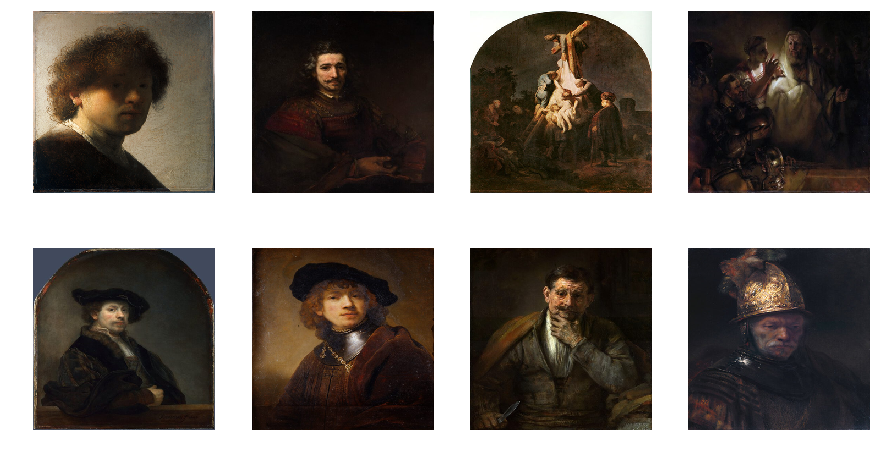

In [96]:
plot_most_similar_artist(42)

Interestingly many of Titian's portraiture resemble those of Rembrandt (maybe similar darker backgrounds of these paintings have fooled the model). Note also the smaller confidence levels the model has given to these paintings compared to those by Edgar Degas. This shows that the model has a harder time classifying the paintings by Titian. One explanation can be that Renaissance paintings are similar in theme (religious themes are prevalent in Renaissance paintings for example). 

Similar to the previous set of paintings, faces are again the most important features that affect the model decisions. 